In [2]:
from warnings import filterwarnings

filterwarnings("ignore")

import sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import qmc
import random 
import time
from sklearn.metrics import mean_squared_error, r2_score

from scipy.integrate import quad

In [3]:
seed = 31

MSE = {}
RMSE = {}
MAE = {}
R2 = {}
Time = {}

MSE_var = {}
RMSE_var = {}
MAE_var = {}
R2_var = {}
Time_var = {}

ms = []

inference_time = {}
mse = {}
r2 = {}

In [8]:
from random import randint
def generate_fourier_random_function(domain_min, domain_max):
    """Generate random function using Fourier series and normalize"""
    n_terms = 7#np.random.randint(7)
    L = domain_max - domain_min
    
    a0 = np.random.randn()
    a_coeffs = np.random.randn(n_terms)
    b_coeffs = np.random.randn(n_terms)
    
    def raw_function(x):
        result = a0/2
        for n in range(1, n_terms+1):
            result += np.array(a_coeffs[n-1]) * np.cos(2*n*np.pi*x/L)
            result += np.array(b_coeffs[n-1]) * np.sin(2*n*np.pi*x/L)
        return result
    
    def positive_function(x):
        return np.log(1 + np.exp(raw_function(x)))
    
    integral, _ = quad(positive_function, domain_min, domain_max)
    
    def normalized_function(x):
        res = []
        for i in x:
            res.append(positive_function(i) / integral)
        # if len(res)==1:
        #     return res[0]
        # else:
        return np.array(res)
    
    return normalized_function

In [10]:
test_size = 10

functions = []

for _ in range(test_size):
    functions.append(generate_fourier_random_function(-1, 1))

In [12]:
l_bounds = [-1.]
u_bounds = [1.]
bounds = [[-1.,1.]]
n_i = 10
train_points = np.linspace(-1, 1, n_i).reshape(-1, 1)

sampler = qmc.LatinHypercube(d=1)
sample = sampler.random(n=1000)
sample_scaled = qmc.scale(sample, -1, 1)
test_points = np.array(sample_scaled).reshape(-1, 1)

n_add = 30

# GP

In [15]:
from gale.doe import SeqED, adaptive_sampling

In [17]:
for as_name in ['GUESS','wMMSE','MMSE','TEAD']:#,'wMMSE','MMSE','TEAD'
    MSE_ = []
    MAE_ = []
    R2_ = []
    Time_ = []
    Time_inf = []

    for f in functions:
        train_answers = f(train_points)
        test_answers = f(test_points)
        
        n_c = n_i+n_add
        ncalls = n_i+n_add

        method = adaptive_sampling[as_name](bounds=bounds,\
                                                n_init=n_i, rnd_state=seed, model="GP",optimizer ="diff_evo",n_max = n_c,init_sampling = train_points,init_sampling_y = train_answers)

        doe = SeqED(fun=f, adaptive_method=method, n_calls=ncalls,verbose=0, eval_performance=1,bench_sampling = test_points,freq=1,\
                                                x=train_points,y=train_answers,y_true=test_answers)
        res = doe.run()
        
        MSE_.append(res['metrics'][0]['results'])
        MAE_.append(res['metrics'][1]['results'])
        R2_.append(res['metrics'][2]['results'])
        Time_.append(np.array(res['ask_time'][n_i:])+np.array(res['tell_time'][n_i:]))
        ms.append(res['model'])

    MSE[as_name] = np.mean(MSE_,axis=0)[1:]
    MSE_var[as_name] = np.var(MSE_,axis=0)[1:]

    RMSE[as_name] = np.mean(np.sqrt(MSE_),axis=0)[1:]
    RMSE_var[as_name] = np.var(np.sqrt(MSE_),axis=0)[1:]
    
    MAE[as_name] = np.mean(MAE_,axis=0)[1:]
    MAE_var[as_name] = np.var(MAE_,axis=0)[1:]
    
    R2[as_name] = np.mean(R2_,axis=0)[1:]
    R2_var[as_name] = np.var(R2_,axis=0)[1:]
    
    Time[as_name] = np.mean(Time_,axis=0)
    Time_var[as_name] = np.var(Time_,axis=0)

# Neural Network

In [19]:
from importlib import reload 
import QBC
QBC = reload(QBC)
from QBC import run_NN_sampling

In [20]:
MSE_ = []
MSE_aggr = []
R2_ = []
R2_aggr = []
Time_ = []


for f in functions:
       train_answers = f(train_points)
       test_answers = f(test_points)

       qbc_model,qbc_models,mse_a,r2_a,qbc_mse,qbc_r2,qbc_t = run_NN_sampling(f,l_bounds,u_bounds,\
                                                                           train_points,train_answers,test_points,\
                                                                           test_answers,INPUT_SIZE=1,n_splits = 3,\
                                                                           nb_points_added=n_add,freq=1) 
        
       MSE_.append(qbc_mse)
       MSE_aggr.append(mse_a)
        
       R2_.append(qbc_r2)
       R2_aggr.append(r2_a)
       Time_.append(qbc_t)

In [21]:
MSE['QBD'] = np.mean(MSE_,axis=0)
R2['QBD'] = np.mean(R2_,axis=0)
R2_var['QBD'] = np.var(R2_,axis=0)

Time['QBD'] = np.mean(Time_,axis=0)

# RL

In [28]:
from environment import Environment
from ddpg_fol.ddpg import DDPG
from sklearn.gaussian_process.kernels import Matern, ConstantKernel

In [29]:
train_points = np.concatenate((train_points,[[0]]*10))

In [30]:
class Arg:
    def __init__(self,):
        self.mode = 'test'
        self.hidden1 = 16
        self.hidden2 = 16
        self.rate =0.0007
        self.prate =0.0007
        self.warmup =200
        self.discount=0.9
        self.bsize=64
        self.rmsize=100000
        self.window_length=1
        self.tau = 0.1
        self.validate_episodes=5
        self.max_episode_length=30
        self.validate_steps=500
        self.output='output_GP'
        self.debug='debug'
        self.init_w=0.003
        self.train_iter=4000
        self.epsilon=4000
        self.seed = 1
        self.resume = 'default'
        
args = Arg()

np.random.seed(args.seed)

nb_states = 20
nb_actions = 1


agent = DDPG(nb_states, nb_actions, args)
agent.load_weights('../output_GP')

In [31]:
MSE_1 = []
MAE_1 = []
R2_1 = []
Time_1 = []

for f in functions:
        train_answers = f(train_points)
        test_answers = f(test_points)

        env = Environment(X = train_points,y = train_answers,l_bounds = [-1],u_bounds = [1],func = f,tes=False, model = 'GP',model_param = {'d':1,'seed':1,'kernel':ConstantKernel(1.0) * Matern([1],nu=1.5),'n_restarts_optimizer':100},state_mode='last_points',N_state=20)
        state = env.reset()
        agent.is_training = False

        m = []
        r = []
        t = []
        for i in range(n_add):
            start = time.time()
            action = agent.select_action(state)
            state, reward, done, info = env.step(action)
            model = env.mod()
            m.append(mean_squared_error(model.predict(test_points),test_answers))
            r.append(r2_score(test_answers,model.predict(test_points)))
            stop = time.time()    
            t.append(stop-start)


        MSE_1.append(m)
        R2_1.append(r)
        Time_1.append(t)

MSE['RLGP_points'] = np.mean(MSE_1,axis=0)
R2['RLGP_points'] = np.mean(R2_1,axis=0)
R2_var['RLGP_points'] = np.var(R2_1,axis=0)
Time['RLGP_points'] = np.mean(Time_1,axis=0)

In [32]:
MSE_2 = []
MAE_2 = []
R2_2 = []
Time_2 = []

for f in functions:
        train_answers = f(train_points)
        test_answers = f(test_points)
        env = Environment(X = train_points,y = train_answers,l_bounds = l_bounds,u_bounds = u_bounds,\
                      func = f,tes=False, model = 'NN',model_param = {'d':1,'nb_nodes':16,'nb_layers':3,'verbose':False,'seed':1,'n_epoches':400},state_mode='last_points',N_state=20)


        state = env.reset()
        agent.is_training = False

        m = []
        r = []
        t = []
        for i in range(n_add):
            start = time.time()
            action = agent.select_action(state)
            state, reward, done, info = env.step(action)
            model = env.mod()
            m.append(mean_squared_error(model.predict(test_points),test_answers))
            r.append(r2_score(test_answers,model.predict(test_points)))
            stop = time.time()    
            t.append(stop-start)


        MSE_2.append(m)
        R2_2.append(r)
        Time_2.append(t)

MSE['RLNN_points'] = np.mean(MSE_2,axis=0)
R2['RLNN_points'] = np.mean(R2_2,axis=0)
R2_var['RLNN_points'] = np.var(R2_2,axis=0)
Time['RLNN_points'] = np.mean(Time_2,axis=0)

In [33]:
class Arg:
    def __init__(self,):
        self.mode = 'train'
        self.hidden1 = 32
        self.hidden2 = 32
        self.rate =0.0007
        self.prate =0.0007
        self.warmup =200
        self.discount=0.9
        self.bsize=64
        self.rmsize=100000
        self.window_length=1
        self.tau = 0.1
        self.validate_episodes=5
        self.max_episode_length=60
        self.validate_steps=500
        self.output='output_GP+'
        self.debug='debug'
        self.init_w=0.003
        self.train_iter=4000
        self.epsilon=10000
        self.seed = 1
        self.resume = 'default'
        
args = Arg()

np.random.seed(args.seed)

nb_states = 40
nb_actions = 1


agent = DDPG(nb_states, nb_actions, args)
agent.load_weights('../output_GP+')

In [34]:
MSE_3 = []
MAE_3 = []
R2_3 = []
Time_3 = []

for f in functions:
        train_answers = f(train_points)
        test_answers = f(test_points)

        env = Environment(X = train_points,y = train_answers,l_bounds = l_bounds,u_bounds = u_bounds,\
                          func = f,tes=False, model = 'GP',model_param = {'d':1,'seed':1,'kernel':ConstantKernel(1.0) * Matern([1],nu=1.5),'n_restarts_optimizer':100},state_mode='predictions+last_points')
        state = env.reset()
        agent.is_training = False

        m = []
        r = []
        t = []
        for i in range(n_add):
            start = time.time()
            action = agent.select_action(state)
            state, reward, done, info = env.step(action)
            model = env.mod()
            m.append(mean_squared_error(model.predict(test_points),test_answers))
            r.append(r2_score(test_answers,model.predict(test_points)))
            stop = time.time()    
            t.append(stop-start)


        MSE_3.append(m)
        R2_3.append(r)
        Time_3.append(t)

MSE['RLGP_points+predictions'] = np.mean(MSE_3,axis=0)
R2['RLGP_points+predictions'] = np.mean(R2_3,axis=0)
R2_var['RLGP_points+predictions'] = np.var(R2_3,axis=0)
Time['RLGP_points+predictions'] = np.mean(Time_3,axis=0)

In [35]:
MSE_4 = []
MAE_4 = []
R2_4 = []
Time_4 = []

for f in functions:
        train_answers = f(train_points)
        test_answers = f(test_points)
        env = Environment(X = train_points,y = train_answers,l_bounds = l_bounds,u_bounds = u_bounds,\
                      func = f,tes=False, model = 'NN',model_param = {'d':1,'nb_nodes':16,'nb_layers':3,'verbose':False,'seed':1,'n_epoches':400},state_mode='predictions+last_points')


        state = env.reset()
        agent.is_training = False

        m = []
        r = []
        t = []
        for i in range(n_add):
            start = time.time()
            action = agent.select_action(state)
            state, reward, done, info = env.step(action)
            model = env.mod()
            m.append(mean_squared_error(model.predict(test_points),test_answers))
            r.append(r2_score(test_answers,model.predict(test_points)))
            stop = time.time()    
            t.append(stop-start)


        MSE_4.append(m)
        R2_4.append(r)
        Time_4.append(t)

MSE['RLNN_points+predictions'] = np.mean(MSE_4,axis=0)
R2['RLNN_points+predictions'] = np.mean(R2_4,axis=0)
R2_var['RLNN_points+predictions'] = np.var(R2_4,axis=0)
Time['RLNN_points+predictions'] = np.mean(Time_4,axis=0)

# Plots

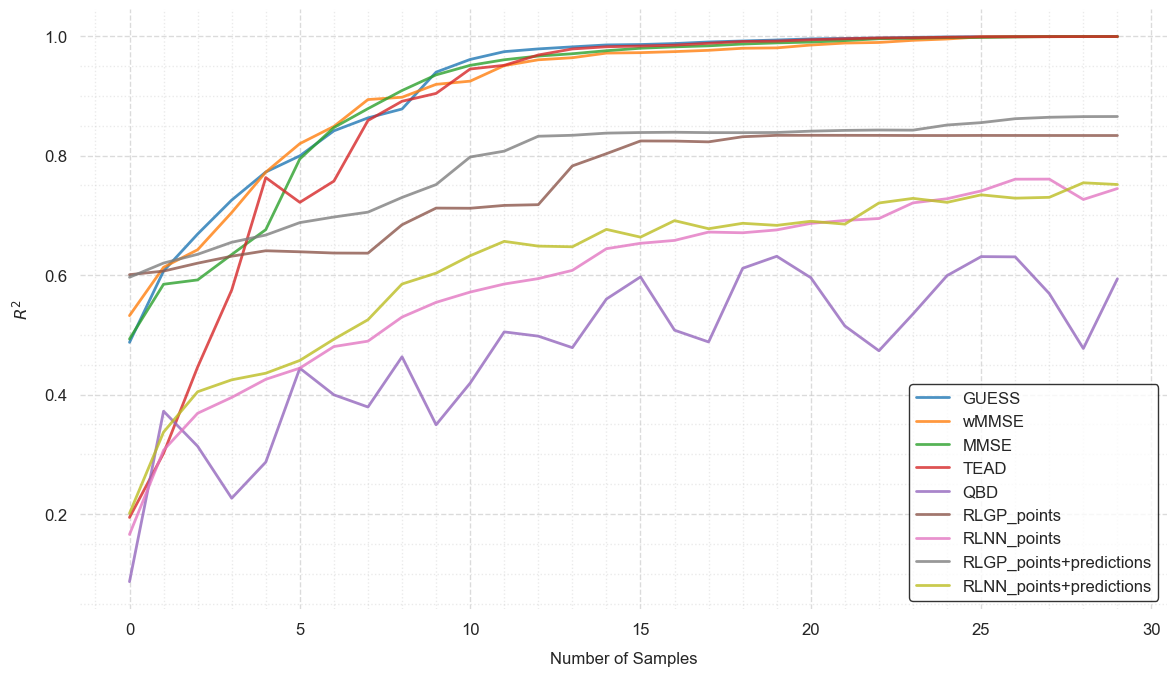

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)
fig, ax = plt.subplots(figsize=(12, 7))
methods =list(MSE.keys())

for i, method in enumerate(['GUESS','wMMSE','MMSE','TEAD','QBD','RLGP_points','RLNN_points','RLGP_points+predictions','RLNN_points+predictions']):
    ax.plot(R2[method], 
            label=method, 
            linewidth=2.,
            alpha=0.8)

ax.set_xlabel('Number of Samples', labelpad=10, fontsize=12)
ax.set_ylabel('$R^2$', labelpad=10, fontsize=12)
legend = ax.legend(loc='lower right',  
                    fontsize=12)
legend.get_frame().set_edgecolor('black')
ax.grid(True, linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which='minor', linestyle=':', alpha=0.4)
ax.minorticks_on()
plt.tight_layout()
# plt.savefig('method_comparison_all.png', dpi=300, bbox_inches='tight')


plt.show()